In [2]:
import pandas as pd
import numpy as np
import string
import nltk
import re
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import string
from transformers import BertTokenizer, BertModel
import torch
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
import re

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#warnings.filterwarnings("ignore", category=UserWarning) 

In [99]:
dfs = []

df_jersey = pd.read_csv('car_data_sorted-NewJersey_.csv')
df_jersey['Price'] = pd.to_numeric(df_jersey['Price'], errors='coerce')
df_jersey = df_jersey[df_jersey['Price'] <= 1000000]
df_jersey = df_jersey.reset_index(drop=True)
df_jersey['Price'] = df_jersey['Price'].astype(int)

files = ['car_data_sorted-Boston_.csv','car_data_sorted-Chicago_.csv','car_data_sorted-Minneapolis_.csv',\
        'car_data_sorted-NY_.csv', 'car_data_sorted-Inlandempire_.csv', 'car_data_sorted-Miami_.csv',\
        'car_data_sorted-Denver_.csv','car_data_sorted-Dallas_.csv','car_data_sorted-Phoenix_.csv',\
         'car_data_sorted-Portland_.csv','car_data_sorted-SanDiego_.csv','car_data_sorted-LA_.csv', \
         'car_data_sorted-SF_.csv', 'car_data_sorted-Seattle_.csv', 'car_data_sorted-OrangeCounty_.csv',\
         'car_data_sorted-Sacramento_.csv','car_data_sorted-Tampa_.csv','car_data_sorted-Atlanta_.csv',\
         'car_data_sorted-Austin_.csv','car_data_sorted-Detroit_.csv','car_data_sorted-Houston_.csv',\
         'car_data_sorted-LasVegas_.csv']
for file in files:   
    df = pd.read_csv(file)
    df = df.replace('',np.nan,regex = True)
    dfs.append(df)
    
dfs.append(df_jersey)

print("Length of 'raw' dataframe: ", len(df))    
df = pd.concat(dfs, axis = 0,sort=True).reset_index(drop = True)
df.drop_duplicates(inplace = True)
df = df.drop_duplicates(subset='Description')
# Reset the index
df = df.reset_index(drop=True)

print('First length of unrefined df: ', len(df))
#df.to_csv('full_df_text.csv')

# Drop and Impute NaNs
unfilled_cars = []
cnt = 0
cnt1 = 0
cnt2 = 0

df = df.loc[(df['Year'] != 0) & (df['Make'] != 0) & (df['Model'] != 0) & (df['Model'] != '0')].reset_index()

# Model adjustments
for i in range(len(df)):
    if (len(df.loc[i,'Model']) == 4 and df.loc[i,'Model'].isdigit())\
    or (df.loc[i,'Model'] == 'Pickup'): # or len(df.loc[i,'Model']) == 1
        df.loc[i,'Model'] = ''
    if (df.loc[i,'Make'] == 'Honda' and df.loc[i,'Model'] == 'Cr'):
        df.loc[i,'Model'] = 'Crv'
    if df.loc[i,'Make'] == 'Alpha':
        df.loc[i,'Make'] = ''
    if df.loc[i,'Make'] == 'Mustang':
        df.loc[i,'Make'] = 'Ford'
        df.loc[i,'Model'] = 'Mustang'
    if (df.loc[i,'Make'] == 'Tesla' and df.loc[i,'Model'] == 'X'):
        df.loc[i,'Model'] = 'Model X'
    if (df.loc[i,'Make'] == 'Tesla' and df.loc[i,'Model'] == 'S'):
        df.loc[i,'Model'] = 'Model S'
    if (df.loc[i,'Make'] == 'Tesla' and df.loc[i,'Model'] == 'Y'):
        df.loc[i,'Model'] = 'Model Y'
    if (df.loc[i,'Make'] == 'Tesla' and df.loc[i,'Model'] == 'M3'):
        df.loc[i,'Model'] = 'Model 3'
    if (df.loc[i,'Make'] == 'Tesla' and df.loc[i,'Model'] == '3'):
        df.loc[i,'Model'] = 'Model 3'

df = df.drop(columns = ['index'])
df1 = df.loc[:,['Make','Model','Cylinders','Drive']]
df_models2 = pd.read_csv('vehicle_models_updated.csv')
df_models21 = df_models2.loc[:,['Make','Model','Cylinders','Drive']]
df_merged = df1.merge(df_models21, how = 'left', on = ['Make','Model'])
df_first1 = df_merged.loc[:,('Make','Model','Cylinders_x', 'Drive_x')].rename(columns={"Cylinders_x": "Cylinders", "Drive_x": "Drive"})
df_models1 = df_merged.loc[:,('Make','Model','Cylinders_y', 'Drive_y')].rename(columns={"Cylinders_y": "Cylinders", "Drive_y": "Drive"})
df_first1 = df_first1[['Cylinders', 'Drive', 'Make', 'Model']]
df_first1 = df_first1.combine_first(df_models1)

df.loc[:,['Cylinders','Drive','Make','Model']] = df_first1

for i in range(len(df)):
    if df.loc[i,'Make'] == 'Tesla':
        df.loc[i,'Fuel'] = 'Electric'
        df.loc[i,'Transmission'] = 'Automatic'
    if (df.loc[i,'Make'] == 'Tesla' or df.loc[i,'Fuel'] == 'Electric'):
        df.loc[i,'Cylinders'] = '0'

for i in range(1,len(df)):
    if not isinstance(df.loc[i,'Color'], str):
        cnt +=1
        df_t = df[(df['Make'] == df.loc[i,['Make']][0]) & (df['Model'] == df.loc[i,['Model']][0])]['Color']
        df_t = df_t[~df_t.isna()]
        try:
            if len(df_t) >= 5:
                cnt1 +=1
                df.loc[i,'Color'] = df_t.mode()[:1][0]
            else:
                raise Exception('Too short')
        except Exception as e: 
                cnt2 +=1
                unfilled_cars.append(str(df.loc[i,['Make']][0])+' '+str(df.loc[i,['Model']][0]))
                pass      

# Price, Odometer, and Year Filters     
print(df.isnull().sum())
df = df.dropna(axis=0)
df.reset_index(drop = True, inplace = True)

#df = pd.concat([df,df_large], axis = 0,sort=True).reset_index(drop = True)

df_m = df

df_m.to_csv('df_m_full_latest.csv', index = False)


Length of 'raw' dataframe:  1402
First length of unrefined df:  58190
Color           1185
Condition          0
Cylinders       2442
Description        1
Drive           3391
Fuel               0
Make               0
Model              0
Odometer           0
Price              0
Title Status       0
Transmission       0
Year               0
dtype: int64


In [105]:
df = df_m

# df.drop(index = 43697,inplace = True)
# df.reset_index(inplace = True)
# df.loc[df['Price'].apply(lambda x: isinstance(x, str)), 'Price'] = df['Price'].astype(int)

# create lower price filter
q_low1 = 900
q_low2 = 1983
# create upper price filter
###########################
q_hi1  = df.Price.quantile(0.98)
#print("High price cutoff: ", q_hi1)
q_hi2  = 350000
q_hi3  = 2024
# filter the data frome
df = df[(df["Price"] < q_hi1) & (df["Price"] > q_low1) & (df["Odometer"] < q_hi2) & (df["Year"] > q_low2) & (df["Year"] < q_hi3)]
df = df[df['Description'].apply(len) <= 1200]
df.reset_index(drop = True, inplace = True)
print('Fourth length of final df: ', len(df))

# Drop NaN        
df = df.replace('',np.nan,regex = True)
df = df.dropna(axis=0)
df.reset_index(drop = True, inplace = True)
print('Length of df: ', len(df))

#df.drop_duplicates(inplace = True)
df_temp = df.groupby(['Make','Model']).size().to_frame().rename(columns = {0: 'count'})
######################################################
df_temp = df_temp[df_temp['count'] >= 17].reset_index()
#df = df.groupby('Make').filter(lambda x : len(x)>19)

df['car'] = ['' for i in range(len(df))]
df.loc[:,('car')] = df["Make"].astype(str) + " " + df["Model"].astype(str)
# df_models2['car'] = df_models2[["Make", "Model"]].apply(" ".join, axis=1)
df_temp['vehicle'] = ['' for i in range(len(df_temp))]
df_temp.loc[:,('vehicle')] = df_temp["Make"].astype(str) + " " + df_temp["Model"].astype(str)
print(len(df))
df = df[df['car'].isin(df_temp['vehicle'])]
print(len(df))
df = df.drop('car', axis = 1)
df = df.reset_index(drop = True)
print(len(df))
#df.drop('index', axis = 1, inplace = True)
print('Final length of final df: ', len(df))

#df = df.dropna(axis=0)
df['Cylinders'] = pd.to_numeric(df['Cylinders']).astype(int)
df['Odometer'] = pd.to_numeric(df['Odometer']).astype(int)
df['Price'] = pd.to_numeric(df['Price']).astype(int)
df['Year'] = pd.to_numeric(df['Year']).astype(int)

df.rename(columns = {'Title Status': 'Title'}, inplace = True)
#Feature Engineering
#df['Condition'].replace({'New': 'Excellent', 'Like New': 'Excellent', 'Fair': 'Good', 'Salvage': "Good"}, inplace = True)
df['Transmission'].replace({'Automatic': 1, 'Manual': 0, 'Other': 0}, inplace = True)
df.rename(columns = {'Transmission': 'Transmission_Automatic'}, inplace = True)
df = df.dropna(axis=0)
df['Description'] = df['Description'].str.lower()
df['Description'] = df['Description'].apply(lambda x: x if x.endswith('.') else x + '.')

punctuation_to_remove = '*#$/|~%<>@'

df['Description'] = df['Description'].apply(lambda x: x.translate(str.maketrans('', '', punctuation_to_remove)) if pd.notnull(x) else x)

prepositions = prepositions = [
                                "aboard", "about", "above", "across", "after", "against", "along", "amid", 
                                "among", "around", "as", "at", "before", "behind", "below", "beneath", 
                                "beside", "between", "beyond", "but", "by", "concerning", "considering", 
                                "despite", "down", "during", "except", "for", "from", "in", "inside", 
                                "into", "like", "near", "of", "off", "on", "onto", "out", "outside", 
                                "over", "past", "regarding", "round", "since", "through", "to", "toward", 
                                "under", "underneath", "until", "unto", "up", "upon", "with", "within", "without"
                              ]


car_makes_models = df.Make.unique().tolist() + df.Model.unique().tolist()
car_makes_models = [cmm.lower() for cmm in car_makes_models]
filter_words = stopwords.words('english') + prepositions + ['i', 'my', 'me',"i'm", "i'll", 'awesome', "i've"] + car_makes_models
translator = str.maketrans('', '', string.punctuation)

def preprocess(text):
    text = text.lower()
    text = text.translate(translator)
    words = text.split()
    words = [word for word in words if word not in filter_words and len(word) > 1 and not (len(word) == 4 and word.isdigit())\
            and not (len(word) == 2 and word.isdigit())]     
    return words

words = [word for description in df['Description'] for word in preprocess(description)]

word_counts = Counter(words)
####################################################################
#top_500_words = [word for word, freq in word_counts.most_common(500)]
top_200_words = [word for word, freq in word_counts.most_common(180)] #180
top_200_words = set(top_200_words)
pattern = '|'.join('\\b'+word+'\\b' for word in top_200_words)

def filter_sentences_optimized(description):
    sentences = re.split(r'(?<=[.!?,])\s+', description)
    filtered_sentences = []

    for sentence in sentences:
        if "serious inquiries" in sentence.lower() or "serious inquires" in sentence.lower():
            continue
        sentence_words = re.findall(r'\b[\w\'@]+\b', sentence)
        top_200_count = sum(word in top_200_words for word in sentence_words)       
        # Fix specific contractions without apostrophes
        sentence = re.sub(r"\bi ve\b", "i've", sentence)
        sentence = re.sub(r"\bi m\b", "i'm", sentence)   
        sentence = re.sub(r"\bdon t\b", "don't", sentence)
        sentence = re.sub(r"\bwon t\b", "won't", sentence)
        sentence = re.sub(r"\bcan t\b", "can't", sentence)
        sentence = re.sub(r"\blet s\b", "let's", sentence)
        sentence = re.sub(r"\doesn t\b", "doesn't", sentence)
        sentence = re.sub(r"\bit s\b", "it's", sentence)
        sentence = re.sub(r"\bisn t\b", "isn't", sentence)
        sentence = re.sub(r"\bhere s\b", "here is", sentence)
        sentence = re.sub(r"\bthere s\b", "there is", sentence)
        #sentence = re.sub(r"(?<!\d)\.|\.(?!\d)", ".", sentence)
        #sentence = re.sub(r"\.\s*\.", ".", sentence) 
        unwanted_words = ['call', 'text', 'at', 'me', 'contact', '@', 'txt', 'email','please','calltext', 'emails'\
                         ,'texts','inquiries','offers','offer','cash','trade','trades','scammmer','price','firm','time',\
                         'waste','sell','i','negotiate','opportunity',"i've","i'm","i'll","i'd","we",'you',"you'll",\
                         'love','contact','question','questions','interested','message','information','phone',\
                         'ask'] + car_makes_models
        if not any(char.isdigit() for char in sentence) and \
        sum(word in sentence_words for word in unwanted_words) < 2\
           and 2 <= len(sentence_words) <= 20 and top_200_count >= 1:
            
            filtered_sentences.append(sentence)
            
    return ''.join(filtered_sentences)

def remove_parentheses(text):
    # Define the pattern to match parentheses and their contents
    pattern = r"\([^()]*\)"    
    # Use the sub() function from the re module to replace the pattern with an empty string
    cleaned_text = re.sub(pattern, '', text)    
    return cleaned_text
# def replace_trailing_comma(text):
#     import re

def fix_text(text):
    # Remove leading/trailing whitespace
    text = text.strip()
    # Replace any whitespace before a period with nothing
    text = re.sub(r'\s+([.])', r'\1', text)
    # If the text ends with a comma, replace the last character (comma) with a period
    if text.endswith(','):
        text = text[:-1] + '.'
    # Replace two or more consecutive periods or a mix of periods and commas at the end with a single period
    text = re.sub(r'([.,]{2,})$', '.', text)
    # Replace two or more consecutive periods anywhere in the text with a single period
    text = re.sub(r'\.{2,}', '.', text)
    
    return text



df['Description'] = df['Description'].str.replace(';', '.')
#df['Description'] = df['Description'].str.replace(',', '.')
df['Description'] = df['Description'].apply(remove_parentheses)
#print(df['Description'][0], '---3')
#print('==========================')
#df['Description'] = df['Description'].str.replace(r'\d+', '')
# Remove extra spaces
df['Description'] = df['Description'].str.replace(r'\s+', ' ', regex=True)
# Replace '&' with 'and'
df['Description'] = df['Description'].str.replace('&', 'and')
df['Description'] = df['Description'].str.replace(r'[?!]', '.', regex=True)

df_old = df[:1000]

# # Define the letters to be removed
# pattern = r'\b[k]\b'  # Replace 'abc' with the specific letters you want to remove

# # Apply the pattern and replace with an empty string
# df['Description'] = df['Description'].str.replace(pattern, '', regex=True)
#features_cat = ["Make", "Color", "Drive",'Fuel', 'Title Status']

df['Description'] = df['Description'].apply(filter_sentences_optimized)
#df['Description'] = df['Description'].str.replace(',', ' ')

#df['Description'] = df['Description'].str.replace('.', ' ')
df['Description'] = df['Description'].astype(str)

df['Description'] = df['Description'].apply(fix_text)

features_cat_basic = ["Make", "Model", "Drive", 'Fuel', 'Title', 'Color','Cylinders', 'Condition']
#price dataframe
df_price = df[['Price']]
df_num = df[["Year",'Odometer']]
df_num_price = pd.concat([df_num, df_price], axis = 1,sort=True)
df_cat_basic = df[features_cat_basic]
df_dum_basic = pd.get_dummies(df_cat_basic.astype(str))

# Get dummies
df_basic = pd.concat([df_dum_basic,df_num,df[['Transmission_Automatic']], df[['Description']]], axis = 1,sort=True)
df_info = pd.DataFrame(np.zeros([1,df_basic.shape[1]]), columns = df_basic.columns).astype(int)
df_basic_old = df_basic.copy()

#df.to_csv('df_latest.csv', index = False)
df.to_csv('df_latest.csv', index = False)
df_basic.to_csv('df_basic_latest.csv', index = False)
df_price.to_csv('df_price_latest.csv', index = False)

Fourth length of final df:  40849
Length of df:  40283
40283
34430
34430
Final length of final df:  34430


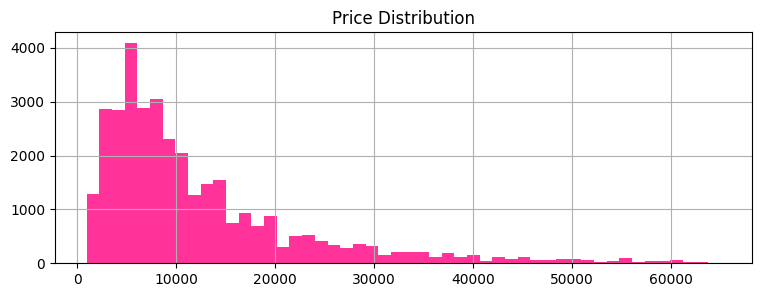

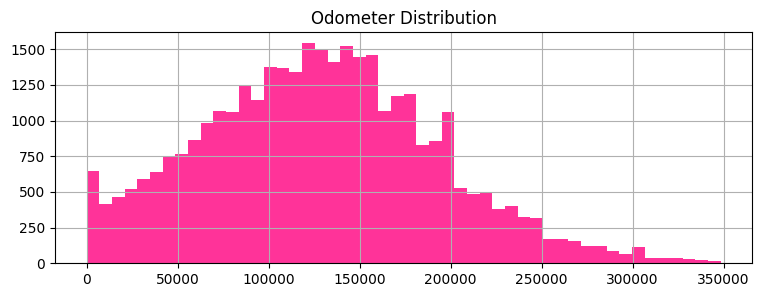

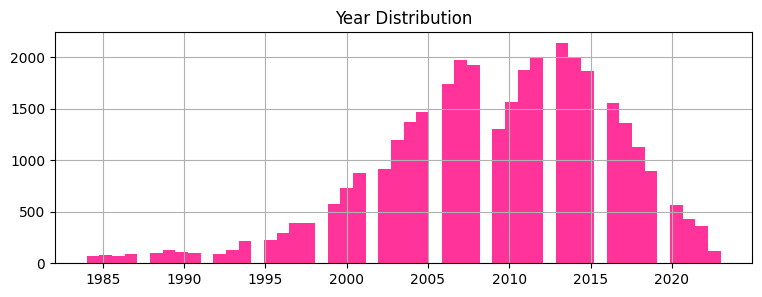

In [3]:
# a different view of the distributions
for i in ["Price", "Odometer","Year"]:
    df[i].hist(bins=50,figsize=(9, 3),color='#FF3399');
    plt.title(i + ' Distribution', loc = 'center');
    plt.show()

74%, 122

In [96]:
#avg_len = int(df['Description'].apply(lambda x: len(x)).mean())
avg_len = int(df['Description'].apply(lambda x: len(x) if isinstance(x, str) else 0).mean())
percentage = int((df[df['Description'].str.len() > 0].shape[0] / df.shape[0]) * 100)
print('Average length of Descpription: ', avg_len)
print('Descpription cells filled: ', percentage , '%')

Average length of Descpription:  122
Descpription cells filled:  74 %


In [98]:
df_temp = df['Description']
for i in range(len(df_temp)):
    #if 'bells and whistles' in df_temp[i]:
    if isinstance(df_temp[i], str):
        print(i)
        print(len(df_temp[i]))
        print(df_temp[i])
        print('-----')

0
42
sequential led tail lights,clean interior.
-----
1
204
white with black leather interior,loaded with all the options.including auto start,light bars.change all fluids,including oil,transmission fluid,rear deferential.water pump.change all the belts.call nick.
-----
2
57
beautiful baseball stitching leather interior,new brakes.
-----
3
189
tinted windows,rear spoiler,backup camera,new battery,factory winter all weather mats,and automatic starter.great car i bought from my dad,only two owners and has been a great reliable car.
-----
4
188
this vehicle is a tank,it has been an amazing vehicle,consistent with the toyota brand.i'm "on the road" to an suv for additional space and must say goodbye.second owner,all terrain tires.
-----
5
92
cold weather package,premium package.we are the original owners.comes with full sized spare.
-----
6
101
fixable both cars are drivable and they both have check engine on.i am selling both cars as they are.
-----
7
223
rare greygreen color.panoramic su

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



83.6%

### XGBoost + GloVe

checkpoint 0
checkpoint 1
R squared: 0.836


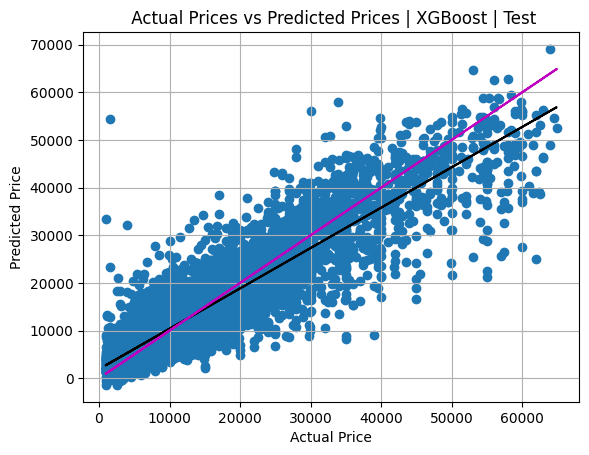

In [119]:
glove_input_file = 'glove.twitter.27B.100d.txt'
#glove_input_file = 'glove.42B.300d.txt'
glove = KeyedVectors.load_word2vec_format(glove_input_file, binary=False, no_header=True)
print('checkpoint 0')

# Function to transform text into a vector
def text_to_vector(text):
    words = text.split()
    word_vectors = [glove[word] for word in words if word in glove.key_to_index]
    return np.mean(word_vectors, axis=0) if len(word_vectors) > 0 else np.zeros(glove.vector_size)

print('checkpoint 1')
# Transform the text data
df_basic_Glove = df_basic.copy()
df_basic_Glove['vector'] = df_basic_Glove['Description'].apply(text_to_vector)
df_basic_Glove = df_basic_Glove.drop(columns = ['Description'])

# Unpack the vector column into separate columns, one for each dimension of the vector
df_vectors = pd.DataFrame(df_basic_Glove['vector'].to_list(), columns=[f'vector_{i}' for i in range(len(df_basic_Glove['vector'][0]))])

# Drop the original vector column
df_basic_Glove.drop(columns=['vector'], inplace=True)

# Concatenate the vector columns back into the original DataFrame
df_basic_Glove = pd.concat([df_basic_Glove, df_vectors], axis=1)

# Split the data into training and test sets
X = df_basic_Glove
y = df_price

test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=0)
bst = XGBRegressor(n_estimators=160,objective='reg:squarederror')
bst.fit(X_train, y_train)

#score = bst.score(X_test, y_test)
y_hat_bst = bst.predict(X_test)

x = y_test; y = y_hat_bst; a, b = np.polyfit(x.Price.values, y, 1); plt.plot(x, a*x+b, '-k'); plt.plot(x, x, '-m')
print("R squared:",round(r2_score(x,y),3));
plt.scatter(x,y); plt.xlabel("Actual Price"); plt.ylabel("Predicted Price");
plt.title(" Actual Prices vs Predicted Prices | XGBoost | Test");plt.grid(); plt.show();

file_path = "/Users/alex/Data_Science/Used_Cars/car_app/xgb_model.pkl"
file_path2 = "xgb_model.pkl"
# save
# pickle.dump(bst, open(file_path, "wb"))
# pickle.dump(bst, open(file_path2, "wb"))


### BERT 

In [123]:
#df_basic = df_basic_old
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def texts_to_vectors(texts):
    print("Starting texts_to_vectors function...")
    
    vectors = []
    for cnt, text in enumerate(texts):
        try:            
            inputs = tokenizer([text], return_tensors="pt", truncation=True, padding=True)
            with torch.no_grad():
                outputs = model(**inputs)
            embeddings = outputs.last_hidden_state
            mask = inputs.attention_mask
            masked_embeddings = embeddings * mask.unsqueeze(-1)
            summed = torch.sum(masked_embeddings, 1)
            summed_mask = torch.clamp(mask.sum(1), min=1e-9)
            mean_pooled = summed / summed_mask.unsqueeze(-1)
            vectors.append(mean_pooled[0].numpy())
        except Exception as e:
            print(f"Error encountered while processing text {cnt}: {e}")
            continue
        # Print progress update every 400 samples
        if cnt % 400 == 0:
            percentage = (cnt / len(texts)) * 100
            print(f"Processing text {cnt} of {len(texts)} ({percentage:.2f}% complete)")
    
    print("Finished converting texts to vectors.")
    return np.array(vectors)

vectors = texts_to_vectors(df_basic['Description'].tolist())
# Unpack the vector column into separate columns, one for each dimension of the vector
df_vectors = pd.DataFrame(vectors, columns=[f'vector_{i}' for i in range(vectors.shape[1])])
# df_vectors.to_csv('df_vectors.csv')

df_basic_bert = df_basic.drop(columns=['Description'])
df_basic_bert = pd.concat([df_basic_bert, df_vectors], axis=1)
df_basic_bert.to_csv('df_basic_bert.csv', index = False)
#duplicate important objects to be safe.
vectors_old = vectors
df_vectors_bert = df_vectors

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting texts_to_vectors function...
Processing text 0 of 34430 (0.00% complete)
Processing text 400 of 34430 (1.16% complete)
Processing text 800 of 34430 (2.32% complete)
Processing text 1200 of 34430 (3.49% complete)
Processing text 1600 of 34430 (4.65% complete)
Processing text 2000 of 34430 (5.81% complete)
Processing text 2400 of 34430 (6.97% complete)
Processing text 2800 of 34430 (8.13% complete)
Processing text 3200 of 34430 (9.29% complete)
Processing text 3600 of 34430 (10.46% complete)
Processing text 4000 of 34430 (11.62% complete)
Processing text 4400 of 34430 (12.78% complete)
Processing text 4800 of 34430 (13.94% complete)
Processing text 5200 of 34430 (15.10% complete)
Processing text 5600 of 34430 (16.26% complete)
Processing text 6000 of 34430 (17.43% complete)
Processing text 6400 of 34430 (18.59% complete)
Processing text 6800 of 34430 (19.75% complete)
Processing text 7200 of 34430 (20.91% complete)
Processing text 7600 of 34430 (22.07% complete)
Processing text 

In [124]:
df_basic_bert.head(1)

,Make_Acura,Make_Alfa,Make_Audi,Make_Bmw,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,Make_Dodge,Make_Fiat,Make_Ford,Make_Gmc,Make_Honda,Make_Hummer,Make_Hyundai,Make_Infiniti,Make_Isuzu,Make_Jaguar,Make_Jeep,Make_Kia,Make_Land Rover,Make_Lexus,Make_Lincoln,Make_Maserati,Make_Mazda,Make_Mercedes,Make_Mercury,Make_Mini Cooper,Make_Mitsubishi,Make_Nissan,Make_Pontiac,Make_Porsche,Make_Ram,Make_Saab,Make_Saturn,Make_Scion,Make_Smart,Make_Subaru,Make_Tesla,Make_Toyota,Make_Volkswagen,Make_Volvo,Model_128I,Model_200,Model_240,Model_3,Model_300,Model_300C,Model_320I,Model_325I,Model_328I,Model_328Xi,Model_330I,Model_335I,Model_350Z,Model_428I,Model_4Runner,Model_5,Model_500,Model_525I,Model_528I,Model_530I,Model_535I,Model_550I,Model_6,Model_650I,Model_9 3,Model_911,Model_A3,Model_A4,Model_A5,Model_A6,Model_A7,Model_Acadia,Model_Accent,Model_Accord,Model_Altima,Model_Armada,Model_Astro,Model_Atlas,Model_Ats,Model_Avalanche,Model_Avalon,Model_Avenger,Model_Beetle,Model_Blazer,Model_Bolt,Model_Boxster,Model_Bronco,Model_Brz,Model_C230,Model_C240,Model_C250,Model_C300,Model_C70,Model_Caliber,Model_Camaro,Model_Camry,Model_Canyon,Model_Caprice,Model_Caravan,Model_Cayenne,Model_Cayman,Model_Cc,Model_Celica,Model_Challenger,Model_Charger,Model_Cherokee,Model_Civic,Model_Clk,Model_Clubman,Model_Cobalt,Model_Colorado,Model_Commander,Model_Compass,Model_Corolla,Model_Corvette,Model_Countryman,Model_Crossfire,Model_Crosstrek,Model_Crown,Model_Cruze,Model_Crv,Model_Ct,Model_Cts,Model_Cube,Model_Cx,Model_Dakota,Model_Dart,Model_Deville,Model_Discovery,Model_Dts,Model_Durango,Model_E150,Model_E250,Model_E320,Model_E350,Model_E450,Model_E500,Model_Eclipse,Model_Econoline,Model_Edge,Model_Elantra,Model_Eldorado,Model_Element,Model_Enclave,Model_Envoy,Model_Eos,Model_Equinox,Model_Es,Model_Es350,Model_Escalade,Model_Escape,Model_Eurovan,Model_Ex35,Model_Excursion,Model_Expedition,Model_Explorer,Model_Express,Model_F,Model_F150,Model_F250,Model_F350,Model_F450,Model_F550,Model_Fiesta,Model_Firebird,Model_Fit,Model_Fj,Model_Fleetwood,Model_Flex,Model_Focus,Model_Forester,Model_Forte,Model_Fortwo,Model_Frontier,Model_Fusion,Model_Fx35,Model_G35,Model_G37,Model_G6,Model_Galant,Model_Genesis,Model_Ghibli,Model_Gl450,Model_Gladiator,Model_Glk,Model_Glk350,Model_Golf,Model_Grand,Model_Gs,Model_Gs300,Model_Gti,Model_Gx,Model_Gx470,Model_H2,Model_H3,Model_Hardtop,Model_Hhr,Model_Highlander,Model_I3,Model_Ilx,Model_Impala,Model_Impreza,Model_Ion,Model_Is,Model_Is250,Model_Jetta,Model_Journey,Model_Juke,Model_Lacrosse,Model_Lancer,Model_Land,Model_Landcruiser,Model_Leaf,Model_Legacy,Model_Lesabre,Model_Liberty,Model_Lr4,Model_Ls,Model_Lucerne,Model_M3,Model_M5,Model_M6,Model_Macan,Model_Magnum,Model_Malibu,Model_Matrix,Model_Maverick,Model_Maxima,Model_Mdx,Model_Miata,Model_Mkt,Model_Mkx,Model_Mkz,Model_Ml350,Model_Model 3,Model_Model S,Model_Model Y,Model_Monte,Model_Montero,Model_Mountaineer,Model_Murano,Model_Mustang,Model_Mx,Model_Navigator,Model_Npr,Model_Nv200,Model_Nx,Model_Odyssey,Model_Optima,Model_Outback,Model_Outlander,Model_Pacifica,Model_Panamera,Model_Passat,Model_Pathfinder,Model_Patriot,Model_Pilot,Model_Prius,Model_Promaster,Model_Pt,Model_Q3,Model_Q5,Model_Q50,Model_Q7,Model_Quattroporte,Model_Quest,Model_Qx56,Model_Qx60,Model_Ram,Model_Range,Model_Range Rover,Model_Ranger,Model_Rav,Model_Rav4,Model_Rdx,Model_Regal,Model_Renegade,Model_Ridgeline,Model_Rio,Model_Rogue,Model_Romeo,Model_Rx,Model_Rx300,Model_Rx350,Model_S,Model_S10,Model_S2000,Model_S4,Model_S40,Model_S430,Model_S5,Model_S500,Model_S550,Model_S60,Model_S80,Model_Santa,Model_Savana,Model_Sc,Model_Scion,Model_Sebring,Model_Sedona,Model_Sentra,Model_Sequoia,Model_Seville,Model_Sienna,Model_Sierra,Model_Silverado,Model_Sky,Model_Sl500,Model_Sl550,Model_Solara,Model_Solstice,Model_Sonata,Model_Sonic,Model_Sorento,Model_Soul,Model_Spark,Model_Sportage,Model_Sprinter,Model_Srx,Model_Suburban,Model_Tacoma,Model_Tahoe,Model_Taurus,Model_Tc,Model_Terrain,Model_Thunderbird,Model

In [115]:
df_basic_bert = pd.read_csv('df_basic_bert_good3.csv')
df_basic_bert.drop(columns = 'Unnamed: 0', inplace = True)

###  XGBoost

checkpoint 4
R squared: 0.815
MSE:  20884334.498667087


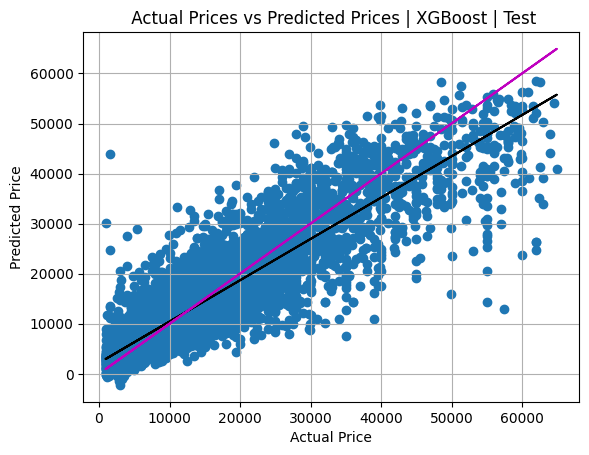

In [141]:
#df_basic = df_basic_bert
#df_basic.drop(columns = ['Description'], inplace = True)
# Split the data into training and test sets
X = df_basic_bert
y = df_price

test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=0)
bst = XGBRegressor(objective='reg:squarederror', max_depth = 10, n_estimators = 70, learning_rate = 0.3,\
                   verbosity = 1) 
# 12, 160, 0.3
# 10, 100, 0.3 MSE: 20793621 R squared: 0.816

bst.fit(X_train, y_train)
# print('checkpoint 3')

#score = bst.score(X_test, y_test)
y_hat_bst = bst.predict(X_test)
print('checkpoint 4')

x = y_test; y = y_hat_bst; a, b = np.polyfit(x.Price.values, y, 1); plt.plot(x, a*x+b, '-k'); plt.plot(x, x, '-m')
print("R squared:",round(r2_score(x,y),3));
print('MSE: ', mean_squared_error(x, y))
plt.scatter(x,y); plt.xlabel("Actual Price"); plt.ylabel("Predicted Price");
plt.title(" Actual Prices vs Predicted Prices | XGBoost | Test");plt.grid(); plt.show();

file_path = "/Users/alex/Data_Science/Used_Cars/price-predictor/MyFunction/xgb_model.pkl"
#"/Users/alex/Data_Science/Used_Cars/car_app/xgb_model.pkl"
file_path2 = "xgb_model_good3.pkl"
# save
# pickle.dump(bst, open(file_path, "wb"))
pickle.dump(bst, open(file_path, "wb"))
pickle.dump(bst, open(file_path2, "wb"))

## Prediction Testing

In [145]:
Make = "Volkswagen"
Model = 'Passat'
Condition = 'Good'
Year = 2012
Odometer = 160000
Drive = 'Fwd'
Fuel = 'Gas'
Title = 'Clean'
Color = 'Grey'
Cylinders = '4'
Transmission = "Automatic"

Description = "check engine light on."
print(len(Description))
# "very good condition."
# "tires are worn out."
# "check engine light on."
# 'a few scratches on the front bumper.'
# 'engine needs to be replaced.'
# 'front windshield is broken.'
# "windshield wipers are missing."
# "new tires."

# stop_words = set(stopwords.words('english'))
# def remove_stopwords(description):
#     word_tokens = word_tokenize(description) 
#     filtered_description = [word for word in word_tokens if not word in stop_words] 
#     return ' '.join(filtered_description)

#Description = remove_stopwords(Description)

#conditions = {'New': 5, 'Like New': 4, 'Excellent': 3, 'Good': 2, 'Fair': 1, 'Salvage': 0}
transmission = {'Automatic': 1, 'Manual': 0, 'Other':0}

Description = Description.strip()

def text_to_vector_glove(text):
    words = text.split()
    word_vectors = [glove[word] for word in words if word in glove.key_to_index]
    return np.mean(word_vectors, axis=0) if len(word_vectors) > 0 else np.zeros(glove.vector_size)

def text_to_vector(text):
    inputs = tokenizer([text], return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    mask = inputs.attention_mask
    masked_embeddings = embeddings * mask.unsqueeze(-1)
    summed = torch.sum(masked_embeddings, 1)
    summed_mask = torch.clamp(mask.sum(1), min=1e-9)
    mean_pooled = summed / summed_mask.unsqueeze(-1)
    return mean_pooled[0].numpy()

vector = text_to_vector(Description)
frame_vectors = pd.DataFrame([vector], columns=[f'vector_{i}' for i in range(len(vector))])

#df_vectors_std = sc.transform(frame_vectors)
# df_vectors_pca = pca.transform(frame_vectors)
# df_vectors_pca = pd.DataFrame(df_vectors_pca, columns=[f'PC_{i}' for i in range(n_components)])

frame = pd.DataFrame(np.zeros([1,df_info.shape[1]]), columns = df_info.columns).drop(columns = ['Description'])
#pd.DataFrame(np.zeros([1,df_info.shape[1]]), columns = df_info.columns).drop(columns = ['Description'])
frame['Make_'+ Make] = 1
frame['Model_'+ Model] = 1
frame['Drive_'+ Drive] = 1
frame['Fuel_'+ Fuel] = 1
frame['Title_'+ Title] = 1
frame['Color_'+ Color] = 1
frame['Condition_' + Condition] = 1
frame['Cylinders_'+ Cylinders] = 1
frame['Year'] = Year
frame['Odometer'] = Odometer
frame['Transmission_Automatic'] = transmission.get(Transmission)
frame = pd.concat([frame, frame_vectors], axis=1)
#frame = pd.concat([frame, df_vectors_pca], axis=1)

print(Description)
print("Price Prediction: $" + str('{:,}'.format(int(bst.predict(frame.values)[0]))))

df_ex = df[(df.Make == Make) & (df.Model == Model) ]#& (df.Condition == Condition) ]#& (df.Year == Year)]# & \
#   (df.Odometer == Odometer) & (df.Year == Year) & (df.Color == Color) & (df.Cylinders == Cylinders)]

display(df_ex.sort_values('Year', ascending = False))



22
check engine light on.
Price Prediction: $7,187


,Color,Condition,Cylinders,Description,Drive,Fuel,Make,Model,Odometer,Price,Title,Transmission_Automatic,Year
12798,Black,Good,5,"alloy wheels new tires,runs like new ,restore ...",Fwd,Gas,Volkswagen,Passat,102146,7300,Rebuilt,1,2023
16240,White,Like New,4,"remote keyless entry,keyless start,heated seat...",Fwd,Gas,Volkswagen,Passat,42000,22900,Clean,1,2020
16707,White,Like New,4,"remote keyless entry,keyless start,heated seat...",Fwd,Gas,Volkswagen,Passat,42000,22900,Clean,1,2020
9259,Blue,Good,4,runs great.good tires.minor blemishes but othe...,Fwd,Gas,Volkswagen,Passat,101000,14500,Clean,1,2018
32141,White,Like New,4,,Fwd,Gas,Volkswagen,Passat,47382,17995,Clean,0,2018
1764,Grey,Excellent,4,"no rust,new tires,tinted windows,heated leathe...",Fwd,Gas,Volkswagen,Passat,48000,16900,Clean,1,2018
3403,Black,Excellent,4,"automatic temperature control,distance pacing ...",Fwd,Gas,Volkswagen,Passat,52203,17995,Clean,1,2017
31597,Black,Like New,4,it's in perfect condition.the salon is clean.t...,Fwd,Gas,Volkswagen,Passat,63000,11500,Rebuilt,1,2017
32666,Blue,Like New,4,,Rwd,Gas,Volkswagen,Passat,93500,10950,Salvage,1,2017
13719,White,Excellent,4,"excellent condition,new tires installed.backup...",Fwd,Gas,Volkswagen,Passat,75000,10500,Salvage,1,2017


### Grid Search

In [83]:
sample_fraction = 0.5 

# Randomly sample the data
df_sample = df_basic_bert.sample(frac=sample_fraction, random_state=1)

# Define your features and target variable
X = df_sample
y = df_price.loc[df_sample.index]

# Split the data into training and testing sets
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

bst = XGBRegressor(objective='reg:squarederror', max_depth=12)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # You can add more values to test
    'n_estimators': [200, 300, 400, 500]  # You can add more values to test
}

bst = XGBRegressor(objective='reg:squarederror', max_depth = 12) #n_estimators=140,
# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=bst, param_distributions=param_grid, cv=3, n_jobs=-1, n_iter=8,\
                                  verbose = 2)
# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
random_search.
print("Best parameters found: ", best_params)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ...............learning_rate=0.01, n_estimators=500; total time=51.7min
[CV] END ................learning_rate=0.1, n_estimators=500; total time=46.9min
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=19.5min
[CV] END ...............learning_rate=0.05, n_estimators=400; total time=39.9min
[CV] END ................learning_rate=0.2, n_estimators=200; total time=18.9min
[CV] END ................learning_rate=0.2, n_estimators=200; total time=18.8min
[CV] END ...............learning_rate=0.01, n_estimators=500; total time=51.7min
[CV] END ................learning_rate=0.1, n_estimators=300; total time=28.4min
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=18.6min
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=19.6min
[CV] END ...............learning_rate=0.01, n_estimators=400; total time=39.8min
[CV] END ................learning_rate=0.2, n_est

In [89]:
# Get the cross-validation results
cv_results = random_search.cv_results_

# Get the scores for each parameter combination
scores = cv_results['mean_test_score']

# Get the parameter combinations
parameters = cv_results['params']

# Print the scores along with the corresponding parameter combinations
for params, score in zip(parameters, scores):
    print("Score: ", score, " for Parameters: ", params)

Score:  0.7573471278556374  for Parameters:  {'n_estimators': 500, 'learning_rate': 0.01}
Score:  0.7647360335294011  for Parameters:  {'n_estimators': 300, 'learning_rate': 0.1}
Score:  0.7652376411532432  for Parameters:  {'n_estimators': 500, 'learning_rate': 0.1}
Score:  0.6833915208639065  for Parameters:  {'n_estimators': 200, 'learning_rate': 0.01}
Score:  0.7655175913814825  for Parameters:  {'n_estimators': 400, 'learning_rate': 0.05}
Score:  0.7520151007631822  for Parameters:  {'n_estimators': 400, 'learning_rate': 0.01}
Score:  0.7555312881485873  for Parameters:  {'n_estimators': 200, 'learning_rate': 0.2}
Score:  0.7647804150675359  for Parameters:  {'n_estimators': 300, 'learning_rate': 0.05}


In [84]:
mse_scores = random_search.cv_results_['mean_test_score']

# Since the scoring method is negative MSE, we need to negate the scores to get the actual MSE
mse_scores = -mse_scores

# Print the MSE scores
print("MSE for each parameter combination: ", mse_scores)

array([0.75734713, 0.76473603, 0.76523764, 0.68339152, 0.76551759,
       0.7520151 , 0.75553129, 0.76478042])

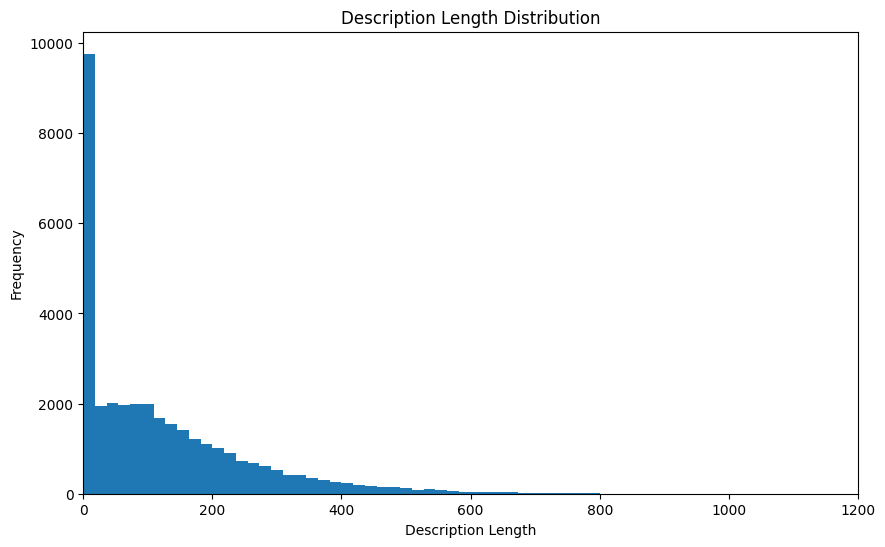

In [111]:
df_lengths = pd.DataFrame(df['Description'].apply(len).values, columns=['description_length'])
#df_lengths['description_length'].describe()
length_distribution = df_lengths['description_length'].value_counts()
plt.figure(figsize=(10,6))
plt.hist(df_lengths['description_length'], bins=50)
plt.xlim([0,1200])
plt.title('Description Length Distribution')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()